In [1]:
# ftp://ngs.sanger.ac.uk/production/ag1000g/phase1/AR3/variation/crosses/ar3/hdf5/ag1000g.crosses.phase1.ar3sites.3L.h5
# ftp://ngs.sanger.ac.uk/production/ag1000g/phase1/AR3/variation/crosses/ar3/hdf5/ag1000g.crosses.phase1.ar3sites.3R.h5


In [7]:
import pickle
import gzip
import random

import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd

%matplotlib inline

# Mendelian simulations

In [3]:
num_sims = 100000
num_ofs = 20

1


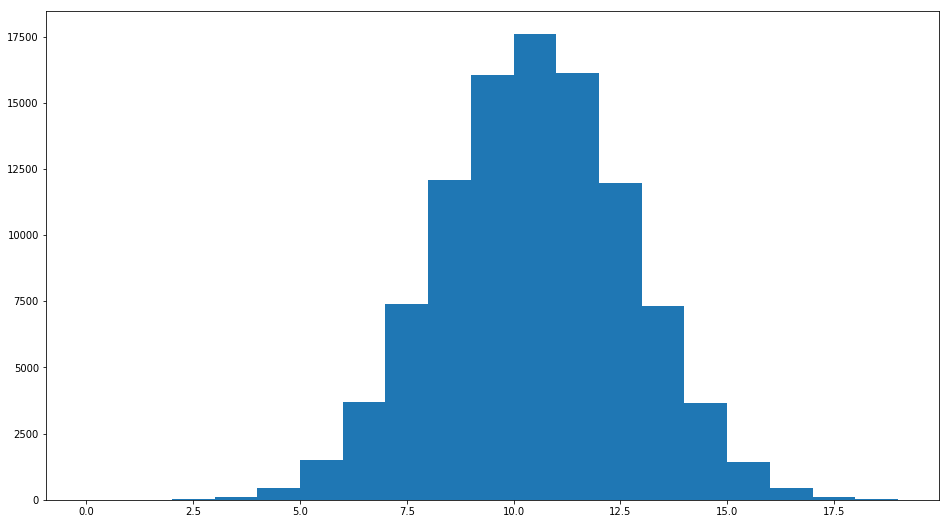

In [4]:
num_hets_AA_AT = []
for sim in range(num_sims):
    sim_hets = 0
    for ofs in range(20):
        sim_hets += 1 if random.choice([0, 1]) == 1 else 0
    num_hets_AA_AT.append(sim_hets)
    
fig, ax = plt.subplots(1,1, figsize=(16,9))
ax.hist(num_hets_AA_AT, bins=range(20))
print(len([num_hets for num_hets in num_hets_AA_AT if num_hets==20]))

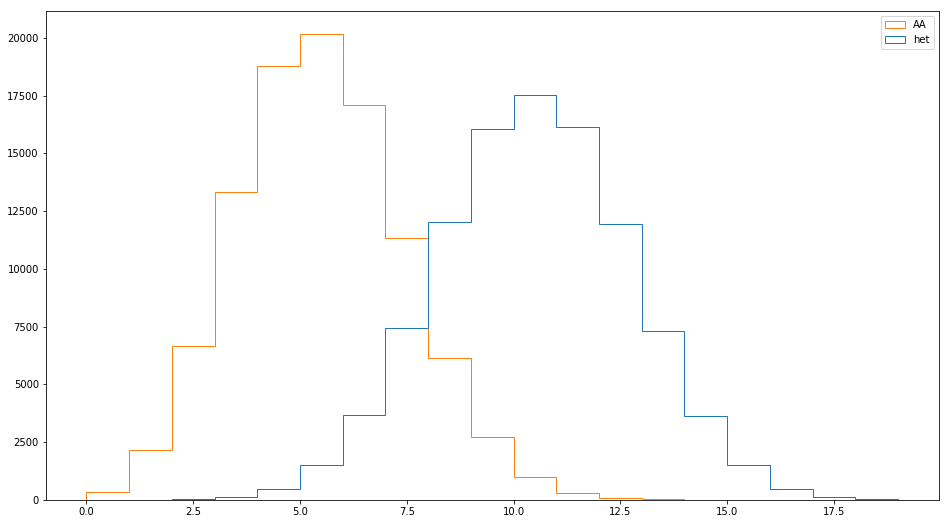

In [5]:
num_AAs_AT_AT = []
num_hets_AT_AT = []
for sim in range(num_sims):
    sim_AAs = 0
    sim_hets = 0
    for ofs in range(20):
        derived_cnt = sum(random.choices([0, 1], k=2))
        sim_AAs += 1 if derived_cnt == 0 else 0
        sim_hets += 1 if derived_cnt == 1 else 0
    num_AAs_AT_AT.append(sim_AAs)
    num_hets_AT_AT.append(sim_hets)
fig, ax = plt.subplots(1,1, figsize=(16,9))
ax.hist([num_hets_AT_AT, num_AAs_AT_AT], histtype='step', fill=False, bins=range(20), label=['het', 'AA'])
plt.legend()

# Data preparation

In [10]:
h5_3L = h5py.File('ag1000g.crosses.phase1.ar3sites.3L.h5', 'r')
samples_hdf5 = list(map(lambda sample: sample.decode('utf-8'), h5_3L['/3L/samples']))
print(samples_hdf5)

calldata_genotype = h5_3L['/3L/calldata/genotype']

MQ0 = h5_3L['/3L/variants/MQ0']
QD = h5_3L['/3L/variants/QD']
QUAL = h5_3L['/3L/variants/QUAL']
FS = h5_3L['/3L/variants/FS']
DP = h5_3L['/3L/variants/DP']
HRun = h5_3L['/3L/variants/HRun']
ReadPosRankSum = h5_3L['/3L/variants/ReadPosRankSum']
my_features = {
    'MQ0': MQ0,
    'QD': QD,
    'QUAL': QUAL,
    'FS': FS,
    'DP': DP,
    'HRun': HRun,
    'ReadPosRankSum': ReadPosRankSum
}

num_alleles = h5_3L['/3L/variants/num_alleles']
is_snp = h5_3L['/3L/variants/is_snp']
POS = h5_3L['/3L/variants/POS']


['AD0231-C', 'AD0232-C', 'AD0234-C', 'AD0235-C', 'AD0236-C', 'AD0237-C', 'AD0238-C', 'AD0239-C', 'AD0240-C', 'AD0241-C', 'AD0242-C', 'AD0243-C', 'AD0244-C', 'AD0245-C', 'AD0246-C', 'AD0247-C', 'AD0248-C', 'AD0249-C', 'AD0250-C', 'AD0251-C', 'AD0252-C', 'AD0253-C', 'AD0254-C', 'AD0255-C', 'AD0259-C', 'AD0260-C', 'AD0261-C', 'AD0262-C', 'AD0263-C', 'AD0265-C', 'AD0266-C', 'AD0267-C', 'AD0268-C', 'AD0269-C', 'AD0270-C', 'AD0271-C', 'AD0272-C', 'AD0273-C', 'AD0274-C', 'AD0275-C', 'AD0276-C', 'AD0305-C', 'AD0306-C', 'AD0309-C', 'AD0310-C', 'AD0311-C', 'AD0312-C', 'AD0313-C', 'AD0314-C', 'AD0315-C', 'AD0316-C', 'AD0317-C', 'AD0318-C', 'AD0319-C', 'AD0320-C', 'AD0322-C', 'AD0323-C', 'AD0347-C', 'AD0348-C', 'AD0351-C', 'AD0352-C', 'AD0353-C', 'AD0354-C', 'AD0355-C', 'AD0356-C', 'AD0357-C', 'AD0358-C', 'AD0359-C', 'AD0360-C', 'AD0361-C', 'AD0362-C', 'AD0363-C', 'AD0364-C', 'AD0365-C', 'AD0366-C', 'AD0367-C', 'AD0368-C', 'AD0369-C', 'AD0370-C', 'AD0438-C']


In [7]:
samples = pd.read_csv('samples.tsv', sep='\t')
print(samples['cross'].unique())
print(samples[samples['cross'] == 'cross-29-2'][['id', 'function']])
print(len(samples[samples['cross'] == 'cross-29-2']))

['cross-29-2' 'cross-36-9' 'cross-42-4' 'cross-46-9']
          id function
0   AD0231-C   parent
1   AD0232-C   parent
2   AD0234-C  progeny
3   AD0235-C  progeny
4   AD0236-C  progeny
5   AD0237-C  progeny
6   AD0238-C  progeny
7   AD0239-C  progeny
8   AD0240-C  progeny
9   AD0241-C  progeny
10  AD0242-C  progeny
11  AD0243-C  progeny
12  AD0244-C  progeny
13  AD0245-C  progeny
14  AD0246-C  progeny
15  AD0247-C  progeny
16  AD0248-C  progeny
17  AD0249-C  progeny
18  AD0250-C  progeny
19  AD0251-C  progeny
20  AD0252-C  progeny
21  AD0253-C  progeny
22


In [1]:
#compute mendelian errors (biallelic)
def compute_mendelian_errors(mother, father, offspring):
    num_errors = 0
    num_ofs_problems = 0
    if len(mother.union(father)) == 1:
        # Mother and father are homo and the same
        for ofs in offspring:
            if len(ofs) == 2:
                # Offspring is het
                num_errors += 1
                num_ofs_problems += 1
            elif len(ofs.intersection(mother)) == 0:
                # Offspring is homo, but opposite from parents
                num_errors += 2
                num_ofs_problems += 1
    elif len(mother) == 1 and len(father) == 1:
        # Mother and father are homo and different
        for ofs in offspring:
            if len(ofs) == 1:
                # Homo, should be het
                num_errors += 1
                num_ofs_problems += 1
    elif len(mother) == 2 and len(father) == 2:
        # Both are het, individual offspring can be anything
        pass
    else:
        # One is het, the other is homo
        homo = mother if len(mother) == 1 else father
        for ofs in offspring:
            if len(ofs) == 1 and ofs.intersection(homo):
                # homo, but not including the allele from parent that is homo
                num_errors += 1
                num_ofs_problems += 1
    return num_errors, num_ofs_problems

In [ ]:
def acceptable_position_to_genotype():
    for i, genotype in enumerate(calldata_genotype):
        if is_snp[i] and num_alleles[i] == 2:
            if len(np.where(genotype == -1)[0]) > 1:
                # Missing data
                continue
            yield i

def acumulate(fun):
    acumulator = {}
    for res in fun():
        if res is not None:
            acumulator[res[0]] = res[1]
    return acumulator

In [ ]:
mother_index = family_indexes['mother']
father_index = family_indexes['father']
offspring_indexes = family_indexes['offspring']
all_errors = {}


def get_mendelian_errors():
    for i in acceptable_position_to_genotype():
        genotype = calldata_genotype[i]
        mother = set(genotype[mother_index])
        father = set(genotype[father_index])
        offspring = [set(genotype[ofs_index]) for ofs_index in offspring_indexes]
        my_mendelian_errors = compute_mendelian_errors(mother, father, offspring)
        yield POS[i], my_mendelian_errors
        if i % 100000 == 0:
            print(POS[i])
        #if i > 100000:
        #    break
        #if mendelian_errors[0] > 0:
        #    #print(POS[i], True, mother, father, offspring)
        #    yield POS[i], my_mendelian_errors
        #else:
        #    yield None

mendelian_errors = acumulate(get_mendelian_errors)

In [ ]:
pickle.dump(mendelian_errors, gzip.open('mendelian_errors.pickle.gz', 'wb'))

In [23]:
ordered_positions = sorted(mendelian_errors.keys())  # Not strictly needed
ordered_features = sorted(my_features.keys())
feature_fit = np.empty((len(ordered_positions), len(my_features) + 1), dtype=float)
current_hdf_row = 0
for column, feature in enumerate(ordered_features):  # 'Strange' order
    print(feature)
    for row, genomic_position in enumerate(ordered_positions):
        if row % 100000 == 0: print(row, POS[current_hdf_row])
        while POS[current_hdf_row] < genomic_position:
            current_hdf_row +=1
        #try:
            feature_fit[row, column] = my_features[feature][current_hdf_row]
        #except:
        #    print(row, genomic_position, feature)
        #    raise ""
    feature_fit[row, len(ordered_features)] = 1 if mendelian_errors[genomic_position][0] > 0 else 0

DP
0 15
100000 1355065
200000 2434614
300000 3340606
400000 4293673
500000 5340223
600000 6181141
700000 6935427
800000 7909437
900000 8541217
1000000 9158354
1100000 9813977
1200000 10468873
1300000 10973653
1400000 11486215
1500000 11960025
1600000 12348520
1700000 12724809
1800000 13092669
1900000 13454030
2000000 13862001
2100000 14240424
2200000 14637144
2300000 14949696
2400000 15270956
2500000 15672270
2600000 16060970
2700000 16484921
2800000 16782864
2900000 17079557
3000000 17367171
3100000 17664353
3200000 18033939
3300000 18355205
3400000 18627519
3500000 18937292
3600000 19246067
3700000 19555219
3800000 19850646
3900000 20172874
4000000 20572570
4100000 20895799
4200000 21216042
4300000 21518250
4400000 21829530
4500000 22174783
4600000 22470600
4700000 22758168
4800000 23044381
4900000 23591695
5000000 23953885
5100000 24263773
5200000 24677567
5300000 24997478
5400000 25290291
5500000 25639399
5600000 25947133
5700000 26221960
5800000 26532419
5900000 26856645
6000000 2

4400000 41963064
4500000 41963064
4600000 41963064
4700000 41963064
4800000 41963064
4900000 41963064
5000000 41963064
5100000 41963064
5200000 41963064
5300000 41963064
5400000 41963064
5500000 41963064
5600000 41963064
5700000 41963064
5800000 41963064
5900000 41963064
6000000 41963064
6100000 41963064
6200000 41963064
6300000 41963064
6400000 41963064
6500000 41963064
6600000 41963064
6700000 41963064
6800000 41963064
6900000 41963064
7000000 41963064
7100000 41963064
7200000 41963064
7300000 41963064
7400000 41963064
7500000 41963064
7600000 41963064
7700000 41963064
7800000 41963064
7900000 41963064
8000000 41963064
8100000 41963064
8200000 41963064
8300000 41963064
8400000 41963064
8500000 41963064
8600000 41963064
8700000 41963064
8800000 41963064
8900000 41963064
9000000 41963064
9100000 41963064
9200000 41963064
9300000 41963064
9400000 41963064
9500000 41963064
9600000 41963064
9700000 41963064
9800000 41963064
9900000 41963064
10000000 41963064
10100000 41963064
10200000 419

In [25]:
np.save(gzip.open('feature_fit.npy.gz', 'wb'), feature_fit, allow_pickle=False, fix_imports=False)
pickle.dump(ordered_features, open('ordered_features', 'wb'))